<a href="https://colab.research.google.com/github/subhambgh/generativeModels/blob/main/GAN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images our discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](https://github.com/subhambgh/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%201/MnistExamples.png?raw=1)



## Generator
We will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation] to map to another shape, a [batch normalization] for stabilization, and finally a non-linear activation function so the output can be transformed in complex ways.

In [ ]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

Generator class will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST).

Finally, we have a forward pass function that takes in a noise vector and generates an image of the output dimension using our neural network.



In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
To be able to use our generator, we will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- random seed. We will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, we will generate all the noise vectors at once.



In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)

## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.

*Note: We use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. 






In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

Now we can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Finally, to use your discrimator's neural network we will write a forward pass function that takes in an image tensor to be classified.


In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
Now putting it all together!
First, we will set the parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, we will load the MNIST dataset as tensors using a dataloader.



In [ ]:
# Setting the parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Loading MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Now, you we initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before we train our GAN, we will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, we will need to call .detach() on the generator result to ensure that only the discriminator is updated!

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

Finally, we can put everything together! For each epoch, we will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss. 

Step 500: Generator loss: 1.3872306059598918, discriminator loss: 0.41939183211326597


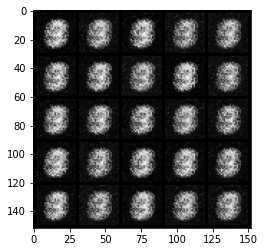

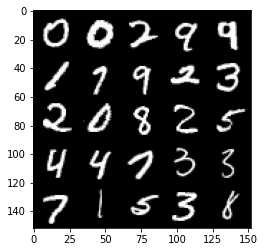

Step 1000: Generator loss: 1.6748489041328432, discriminator loss: 0.29939648330211666


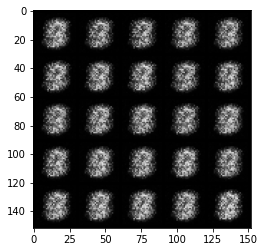

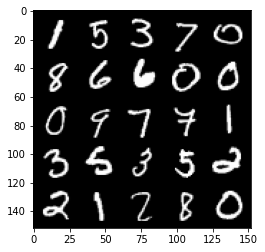

Step 1500: Generator loss: 1.9578317644596124, discriminator loss: 0.17464603891968736


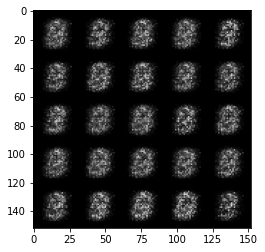

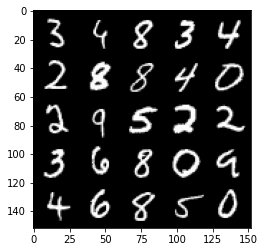

Step 2000: Generator loss: 1.7696685175895692, discriminator loss: 0.19598198267817502


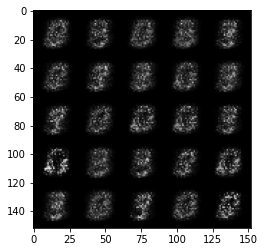

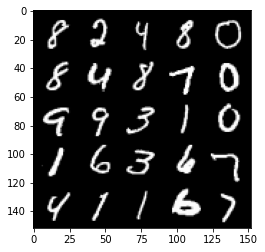

Step 2500: Generator loss: 1.7395678863525397, discriminator loss: 0.19401030042767511


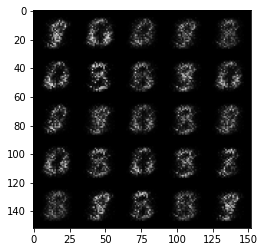

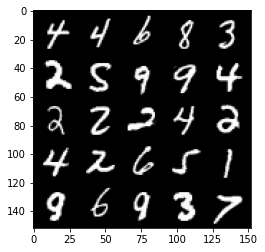

Step 3000: Generator loss: 2.023445904016494, discriminator loss: 0.1492347594201564


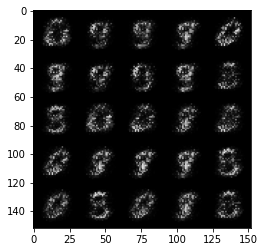

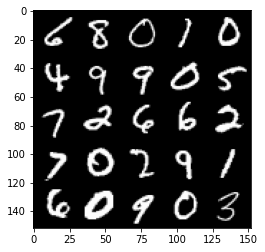

Step 3500: Generator loss: 2.371977590560911, discriminator loss: 0.1339101475030184


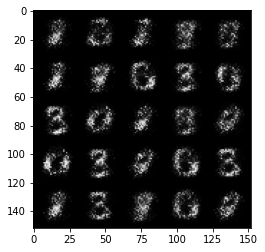

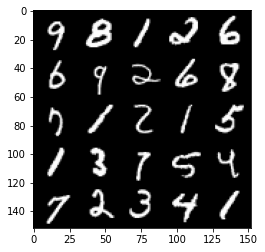

Step 4000: Generator loss: 2.818295852661136, discriminator loss: 0.11921878316998476


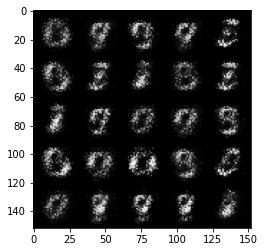

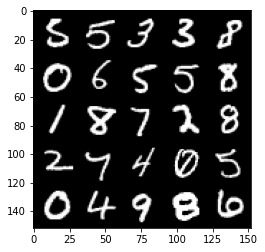

Step 4500: Generator loss: 3.0097831749916075, discriminator loss: 0.10726543416082857


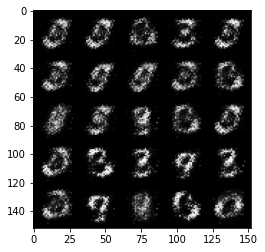

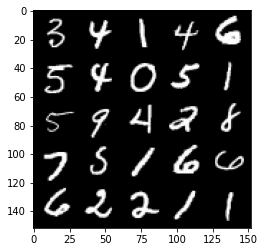

Step 5000: Generator loss: 3.3400547513961794, discriminator loss: 0.0891969714909792


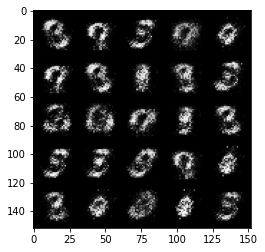

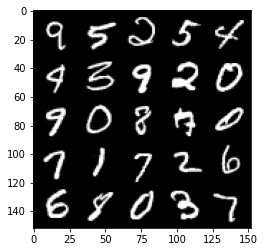

Step 5500: Generator loss: 3.585793558120732, discriminator loss: 0.08606971208006138


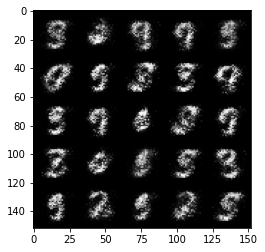

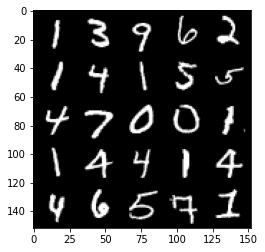

Step 6000: Generator loss: 3.51070521736145, discriminator loss: 0.07761803778260937


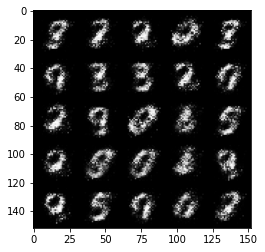

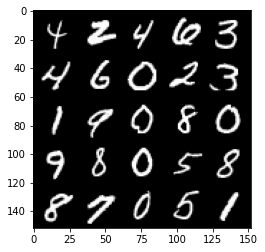

Step 6500: Generator loss: 3.7485396623611456, discriminator loss: 0.06420550545305014


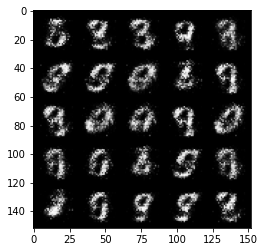

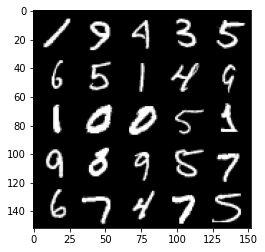

Step 7000: Generator loss: 4.026082419872283, discriminator loss: 0.05117560049518943


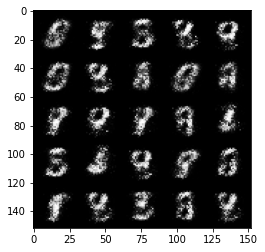

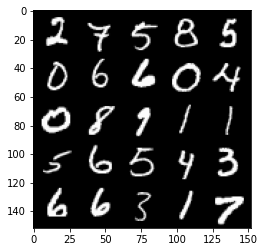

Step 7500: Generator loss: 4.149444035530091, discriminator loss: 0.04367650759965178


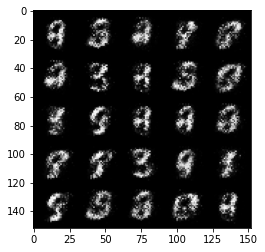

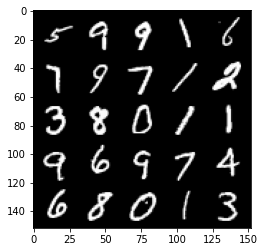

Step 8000: Generator loss: 4.1698419303894045, discriminator loss: 0.05643171729519966


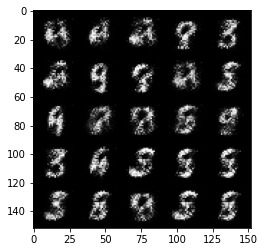

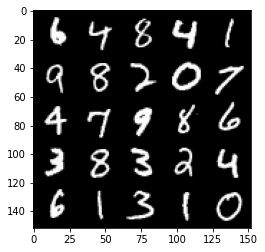

Step 8500: Generator loss: 4.26853203678131, discriminator loss: 0.06361597156524662


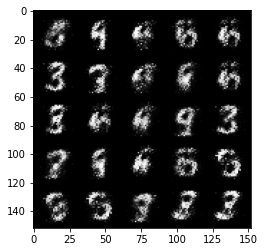

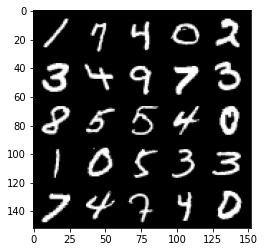

Step 9000: Generator loss: 4.402144775867458, discriminator loss: 0.053290660537779366


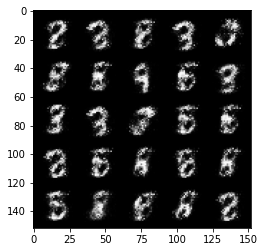

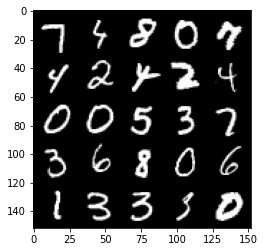

Step 9500: Generator loss: 4.0899207596778835, discriminator loss: 0.06570209702849387


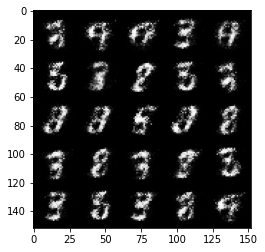

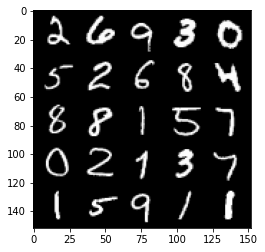

Step 10000: Generator loss: 4.029370459556581, discriminator loss: 0.06590663115680215


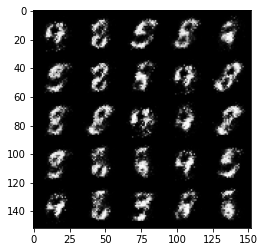

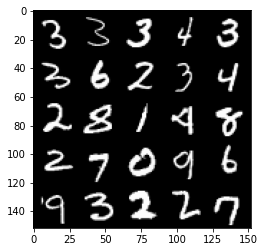

Step 10500: Generator loss: 4.154435450077053, discriminator loss: 0.0665609229430556


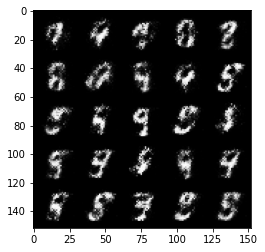

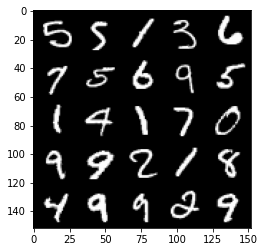

Step 11000: Generator loss: 3.9417248411178556, discriminator loss: 0.08534322950989008


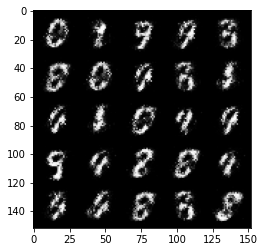

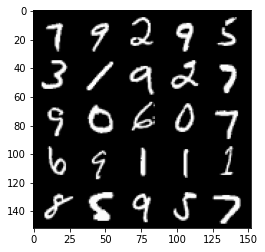

Step 11500: Generator loss: 3.863892282962802, discriminator loss: 0.08265371312201025


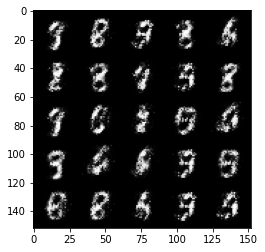

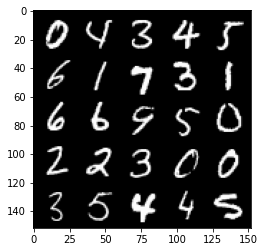

Step 12000: Generator loss: 3.9625327754020696, discriminator loss: 0.07315275138616566


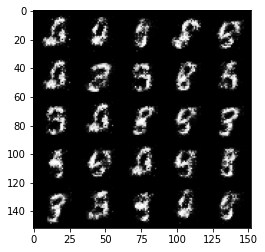

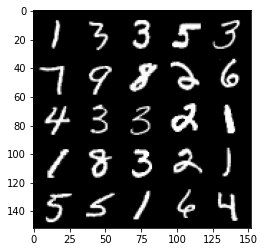

Step 12500: Generator loss: 3.9840987076759324, discriminator loss: 0.07767232155054812


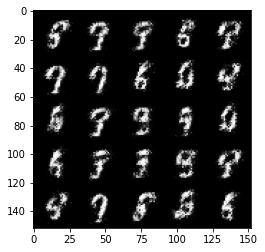

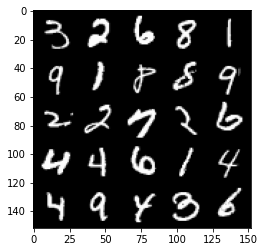

Step 13000: Generator loss: 3.9646985044479366, discriminator loss: 0.08594810723513359


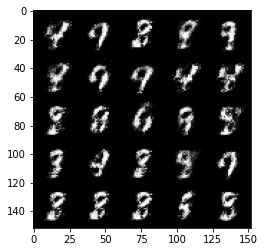

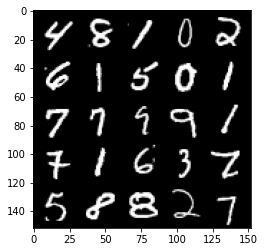

Step 13500: Generator loss: 3.905824874877928, discriminator loss: 0.091164858661592


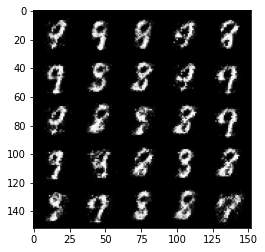

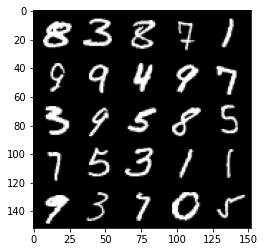

Step 14000: Generator loss: 3.9276322431564332, discriminator loss: 0.08700361374020578


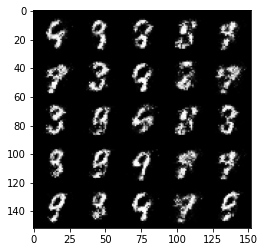

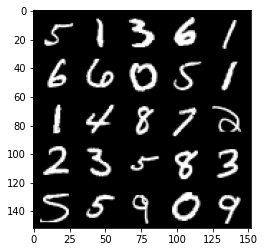

Step 14500: Generator loss: 3.630690759658815, discriminator loss: 0.11008211761713033


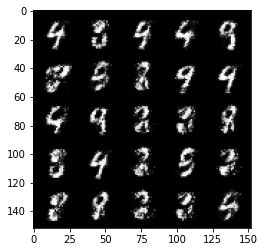

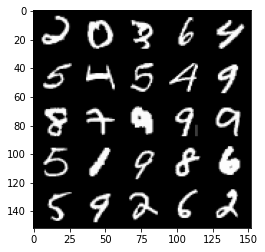

Step 15000: Generator loss: 3.7389449820518497, discriminator loss: 0.09589577188342806


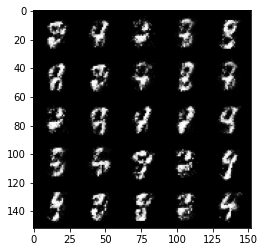

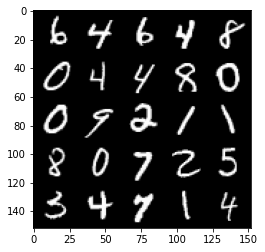

Step 15500: Generator loss: 3.8860842671394358, discriminator loss: 0.09663183242827651


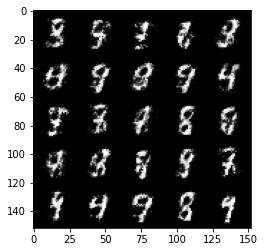

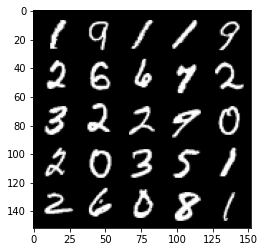

Step 16000: Generator loss: 3.8046610260009754, discriminator loss: 0.10698097981512544


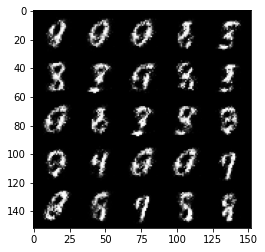

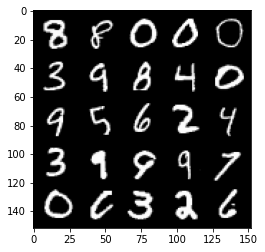

Step 16500: Generator loss: 3.7513045420646667, discriminator loss: 0.12344800883531562


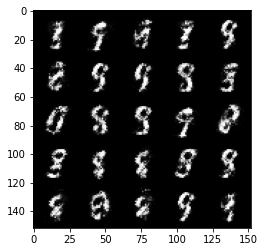

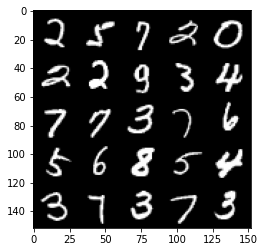

Step 17000: Generator loss: 3.6709163141250603, discriminator loss: 0.13198134628683342


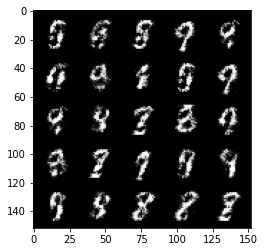

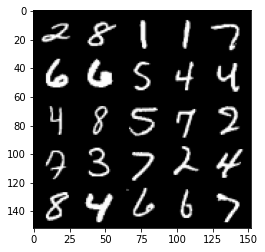

Step 17500: Generator loss: 3.4181482529640226, discriminator loss: 0.150704787299037


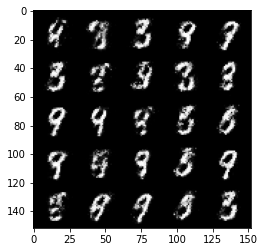

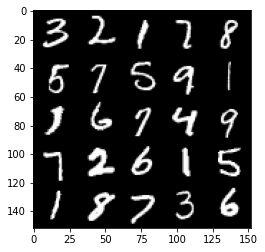

Step 18000: Generator loss: 3.3895788364410366, discriminator loss: 0.12762802910804755


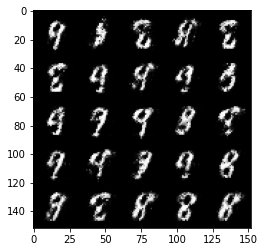

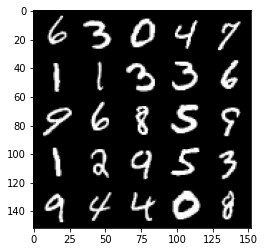

Step 18500: Generator loss: 3.521830053329466, discriminator loss: 0.13571565079689013


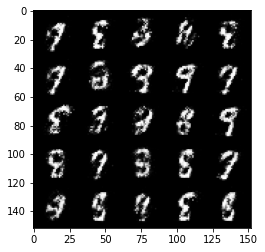

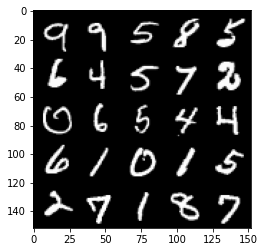

Step 19000: Generator loss: 3.447104408740997, discriminator loss: 0.14606866367161273


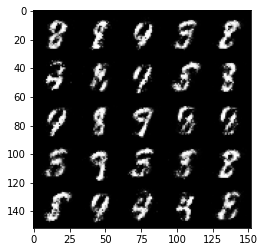

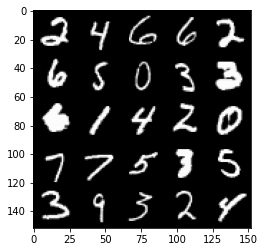

Step 19500: Generator loss: 3.3463971247672997, discriminator loss: 0.1426893839985133


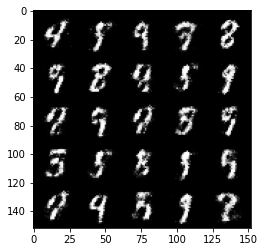

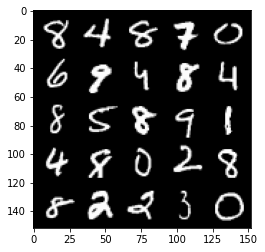

Step 20000: Generator loss: 3.2973222622871394, discriminator loss: 0.14440613618493087


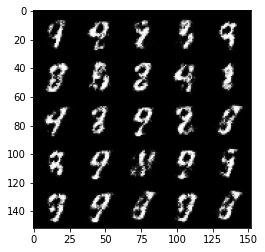

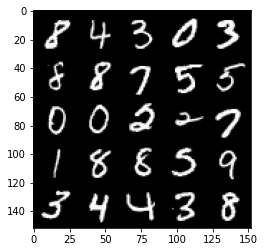

Step 20500: Generator loss: 3.2827043628692643, discriminator loss: 0.1508427238911392


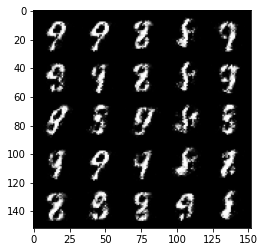

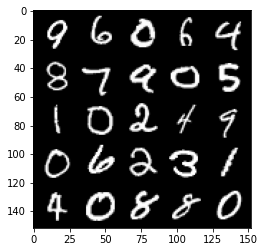

Step 21000: Generator loss: 3.27100757074356, discriminator loss: 0.14783078271150582


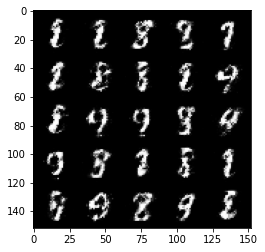

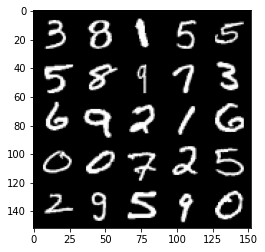

Step 21500: Generator loss: 3.2561663241386434, discriminator loss: 0.1564372597634791


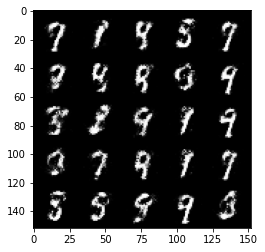

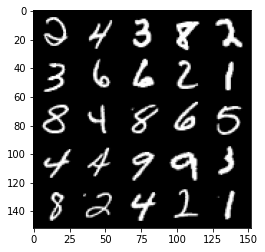

Step 22000: Generator loss: 3.1350398283004783, discriminator loss: 0.1765139196962117


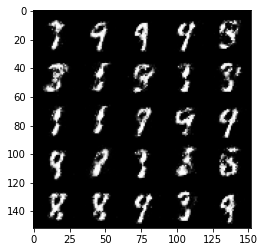

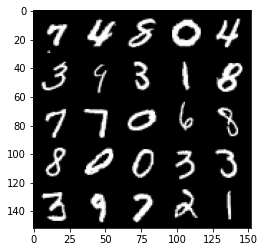

Step 22500: Generator loss: 3.153308006763457, discriminator loss: 0.1680043824613094


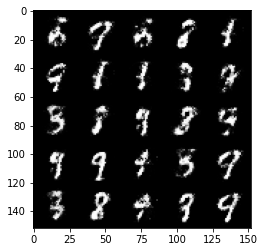

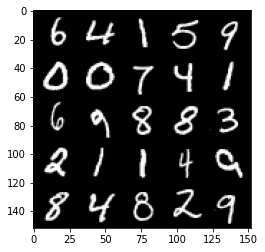

Step 23000: Generator loss: 2.9743014216423007, discriminator loss: 0.1813599346429111


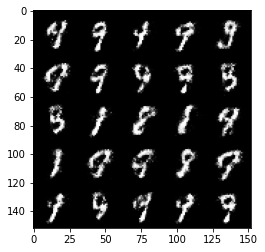

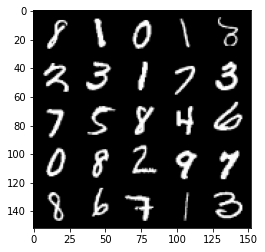

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
losses=[]
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            losses.append((mean_discriminator_loss, mean_generator_loss))
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


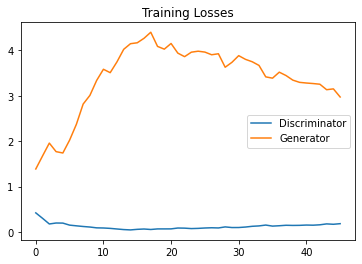

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()